In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss, train_NN, test_loss_Unet, train_U_NET

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 1
image_size = (256,256)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

In [4]:
from Models import U_Net_ASL

U_NN_ASL = U_Net_ASL(input_shape, size_out=3, expansion_rate=1, device=device)

summary(U_NN_ASL, input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
U_Net_ASL                                     [1, 3, 256, 256]          --
├─ModuleDict: 1-1                             --                        --
│    └─Sequential: 2-1                        [1, 64, 256, 256]         --
│    │    └─CSC_block: 3-1                    [1, 64, 256, 256]         280
│    │    └─CSC_block: 3-2                    [1, 64, 256, 256]         8,576
│    └─MaxPool2d: 2-2                         [1, 64, 128, 128]         --
│    └─Sequential: 2-3                        [1, 128, 128, 128]        --
│    │    └─CSC_block: 3-3                    [1, 128, 128, 128]        12,736
│    │    └─CSC_block: 3-4                    [1, 128, 128, 128]        33,536
│    └─MaxPool2d: 2-4                         [1, 128, 64, 64]          --
│    └─Sequential: 2-5                        [1, 256, 64, 64]          --
│    │    └─CSC_block: 3-5                    [1, 256, 64, 64]          50,048
│   

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(U_NN_ASL .parameters(), lr=0.01, momentum=0.99)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_U_NET(U_NN_ASL, train_dataloader,
        test_dataloader, epochs=1, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=500, print_test=True)

[1,   500] train_loss: 1.023
test_loss: 1.047, test_accuracy: 52.428443908691406
[1,  1000] train_loss: 0.999
test_loss: 0.957, test_accuracy: 58.72089385986328
[1,  1500] train_loss: 0.962
test_loss: 0.955, test_accuracy: 55.54621887207031
[1,  2000] train_loss: 0.972
test_loss: 0.940, test_accuracy: 53.79022979736328
[1,  2500] train_loss: 0.935
test_loss: 0.875, test_accuracy: 61.55952453613281
[1,  3000] train_loss: 0.914
test_loss: 0.882, test_accuracy: 61.084800720214844
[1,  3500] train_loss: 0.913
test_loss: 0.962, test_accuracy: 51.12786102294922


In [9]:
torch.save(U_NN_ASL, "./models/U_Net/U_NN_ASL.pth")

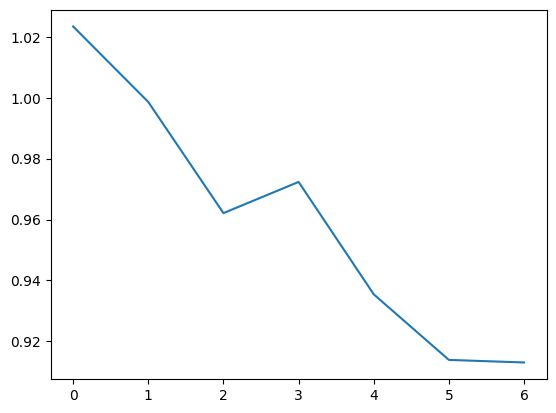

In [10]:
plt.plot(U_NN_ASL.train_loss, label="train_loss")
plt.show()

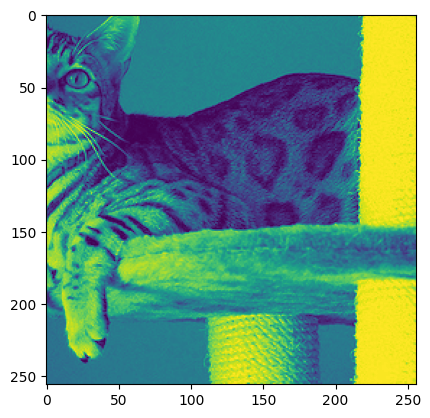

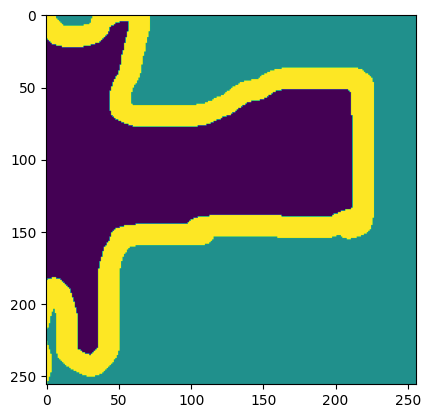

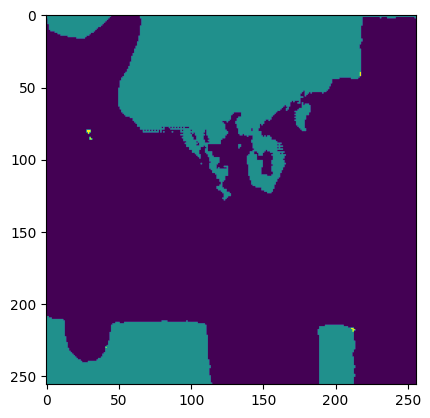

In [21]:
for i, data in enumerate(test_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            plt.imshow(inputs[0][0].detach().to("cpu").numpy())
            plt.show()

            plt.imshow(labels[0][0].detach().to("cpu").numpy())
            plt.show()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = U_NN_ASL(inputs)
            outputs = torch.argmax(outputs, 1, keepdim=True)
            plt.imshow(outputs[0][0].detach().to("cpu").numpy())
            break
            outputs = torch.permute(outputs, (0, 2, 3, 1))
            batch_size = outputs.size()[0]
            outputs = outputs.reshape(batch_size*256*256, 3)
            #outputs = torch.argmax(outputs, 1, keepdim=True).to(torch.float)
            #outputs = outputs.reshape(-1, 256 * 256)
            #outputs = outputs.reshape(-1, 256 * 256)
            #labels = labels.to(torch.int8)
            #labels = labels.reshape(-1, 256*256)
            labels = labels.reshape(batch_size*256*256)
            labels = labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()